## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import math

In [2]:
def design_matrix(model_name, x):
    if model_name == "POLY-4":
        X = np.column_stack([np.ones(len(x)), x, x**2, x**3, x**4])
    elif model_name == "CUBIC":
        X = np.column_stack([np.ones(len(x)), x, x**2, x**3])
    elif model_name == "PAR":
        X = np.column_stack([np.ones(len(x)), x, x**2])
    elif model_name == "LIN":
        X = np.column_stack([np.ones(len(x)), x])
    elif model_name == "LIN0":
        X = x.reshape(-1, 1)  # Only x as a feature (no intercept)
    else:
        raise NotImplementedError(model_name)
    return X

def fit_model(model_name, x, y):
    """Fits the specified model using statsmodels (OLS)."""
    model = sm.OLS(y, design_matrix(model_name, x))
    results = model.fit()
    return results

def predict(model_name, x, y, x_to_predict=None):
    fit_results = fit_model(model_name, x, y)
    if x_to_predict is None:
        x_to_predict = x
    return fit_results.predict(design_matrix(model_name, x_to_predict))

In [3]:
def generate_y(x, noise_std=0.0):
    """Generates data based on the specified model."""
    y = 0.5 + 0.5 * np.tanh(x - 2)
    if noise_std:
        y += np.random.normal(0, noise_std, size=len(x))
    return y

def generate_x(x_range, step=0.1):
    return np.round(np.arange(x_range[0], x_range[1] + step, step), decimals=1)

In [4]:
# Define x ranges
x_ranges = {
    "X0": (0, 3.5),
    "Xtarg": (3.5, 5),
    "Xall": (0, 5),
    "Xcal": (0, 2.5),
    "Xgen": (2.5, 3.5),
}

x_all = generate_x(x_ranges["Xall"])
y_true = generate_y(x_all)
f_dict = {x: y for x, y in zip(x_all, y_true)} # ensure exact same y's for all ranges

## Replicate Fig. 5


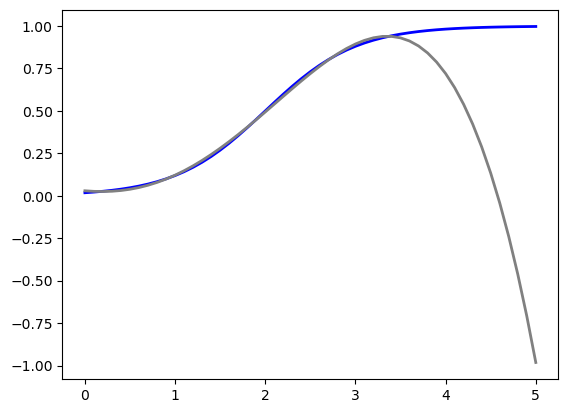

In [5]:
x = generate_x(x_ranges["X0"])
y = np.array([f_dict[x_i] for x_i in x])
y4 = predict("POLY-4", x, y, x_to_predict=x_all)
plt.plot(x_all, y_true, label="TRUE", color="blue", linewidth=2)
plt.plot(x_all, y4, label="POLY-4", color="gray", linewidth=2);

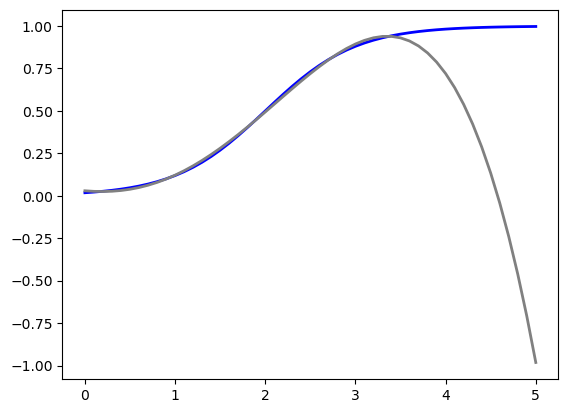

In [6]:
x = generate_x(x_ranges["X0"])
y = np.array([f_dict[x_i] for x_i in x])
y4 = predict("POLY-4", x, y, x_to_predict=x_all)
plt.plot(x_all, y_true, label="TRUE", color="blue", linewidth=2)
plt.plot(x_all, y4, label="POLY-4", color="gray", linewidth=2);

## Replicate Table 2

In [7]:
def score(y_pred, y):
    return np.mean((y_pred - y)**2) * 100000

In [8]:
def _set_ranges(range_name_item):
    x_range = x_ranges[range_name_item[0]]
    x = generate_x(x_range)
    y = np.array([f_dict[x_i] for x_i in x])
    x_out_range = x_ranges[range_name_item[1]]
    x_out = generate_x(x_out_range)
    y_out = np.array([f_dict[x_i] for x_i in x_out])
    return x, y, x_out, y_out


def _display_table(models, names, results_dict):
    table_data = [[results_dict[range_name][model]["score"] for range_name in names] for model in models]
    df = (
        pd.DataFrame(table_data, index=models)
          .astype(int)
          .rename_axis(None, axis=1).rename(columns={i: name for i, name in enumerate(names)})
    )
    display(df)


def run_gen_simulation(range_name_items, models):
    """Runs the simulation and returns the results."""
    results_dict = {}
    names = []
    for item in range_name_items:
        name = f"{item[0]}->{item[1]}"
        results_dict[name] = {}
        names.append(name)
        x, y, x_out, y_out = _set_ranges(item)
        for model_name in models:
            y_pred = predict(model_name, x, y, x_to_predict=x_out)
            results_dict[name][model_name] = {
                "score": round(score(y_pred, y_out), 0),
            }
    _display_table(models, names, results_dict)

sim_models = list(reversed(["POLY-4", "CUBIC", "PAR", "LIN", "LIN0"]))
run_gen_simulation([("Xcal", "Xgen"), ("X0", "Xtarg"), ("X0", "Xall")], sim_models)

,Xcal->Xgen,X0->Xtarg,X0->Xall
LIN0,2779,3520,1677
LIN,818,8220,2851
PAR,8683,24830,7954
CUBIC,5260,12133,3822
POLY-4,1486,84795,26608
